# Solução Case Data Science - Zé Delivery

**Autor**: Maurício Reis do Nascimento

A solução abaixo refere-se à resolução do problema proposto na competição Walmart Recruiting - Store Sales Forecasting. O problema consiste em realizar previsão de demanda para um intervalo de 38 semanas, para vários departamentos de diferentes lojas do Walmart.

Índice das seções:
* [Leitura dos Dataframes](#leitura-dfs)
* [Análise e correção dos tipos de variáveis](#var-types)
* [EDA](#EDA)
    - [Análise dos nulos](#anl-nulls)
    - [Imput de nulos](#imput-nulls)
* [Análise de Correlações e PPS](#anl-corr)
    - [Correlações](#corr)
    - [PPS](#PPS)
* [Modelo Baseline](#baseline)
    - [Data Prep](#dataprep)
    - [Métrica de Avaliação](#eval)
    - [Função de validação cruzada](#cross-val)
* [Feature Engineering](#feat-eng)
    - [Variáveis de distância para o Natal e para o próximo feriado](#natal)
    - [Classificação dos feriados](#holidays)
    - [Variável de lag 52 semanas](#lag52)
    - [Classificação das semanas (clustering)](#cluster-weeks)
    - [Classificação dos depts (clustering)](#cluster-depts)
* [Ajuste de modelos](#models)
    - [Construção do Pipeline](#pipeline)
* [Ajuste de Hiperparâmetros](#hyperparam)
* [Submissão](#sub)
* [Resultado](#result)
* [Próximos passos/ Oportunidades de melhoria](#next-steps)




In [ ]:
!pip install ppscore
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import optuna

import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

<a id='leitura-dfs'></a>
# Leitura e união dos datasets

In [ ]:
path = r'../input/walmart-recruiting-store-sales-forecasting/'

train = pd.read_csv(os.path.join(path, 'train.csv.zip'))
test = pd.read_csv(os.path.join(path, 'test.csv.zip'))
stores = pd.read_csv(os.path.join(path, 'stores.csv'))
features = pd.read_csv(os.path.join(path, 'features.csv.zip'))

In [ ]:
# Juntando os Dataframes de treino e teste para facilitar a manipulação
train['df_label'] = 'train'
test['df_label'] = 'test'

full_df = pd.concat([train, test], axis=0)

In [ ]:
# Agregando ao Dataframe principal variáveis de store
full_df = pd.merge(
    full_df,
    stores,
    how='left',
    on='Store'
)

# Agregando ao Dataframe principal variáveis de features
full_df = pd.merge(
    full_df,
    features,
    how='left',
    on=[
        'Store',
        'Date',
        'IsHoliday'
    ]
)

<a id="var-types"></a>
# Análise e correção dos tipos de variáveis

In [ ]:
# Análise dos tipos de dados
full_df.dtypes

In [ ]:
# Coluna date está como object
# Necessário transformá-la para datetime
full_df['Date'] = pd.to_datetime(full_df['Date'])

* Ao olharmos as datas, podemos perceber que não temos todos os dias representados no dataset e, além disso, elas parecem ser igualmente espaçadas. Vamos explorar melhor este tema:

In [ ]:
# Visualizando, de forma ordenada, as datas presentes
# no dataframe
full_df['Date'].drop_duplicates().sort_values()

* De fato, parece que os dias estão igualmente espaçados por uma janela de 7 dias. Para comprovar isso, podemos olhar para os dias da semana presentes no Dataframe****

In [ ]:
# Visualizando dias da semana presentes no dataset
full_df['Date'].dt.weekday.value_counts()

* Ao verificarmos os dias da semana presentes no dataset, percebemos que todas as datas correspondem à sexta-feira. Além disso, as demais variáveis são agrupadas semanalmente, então vamos transformar a variável de data para semana, criando uma variável para semana do ano, uma variável para semana corrida, uma variável para dia e uma variável para ano****

In [ ]:
# Cria variável de semana do ano
full_df['WeekOfYear'] = full_df.Date.dt.isocalendar().week

# Cria variável referente ao ano
full_df['Year'] = full_df.Date.dt.year

# Cria variável referente ao dia do mês
full_df['Day'] = full_df.Date.dt.day

# Cria variável referente à semana corrida
full_df['WeekSeq'] = full_df['WeekOfYear'] + 52*(full_df['Year'] - full_df['Year'].min())

In [ ]:
# Visualizando o dataset
full_df.head()

<a id='EDA'></a>
# Análise Exploratória (EDA)

In [ ]:
# Visualizando o dataset
display(full_df.head())
display(full_df.tail())

In [ ]:
# Verificando estatísticas das variáveis do Dataframe completo
full_df.describe().T

### Observações:

* Store e Dept: 45 lojas e 99 departamentos diferentes. Isto aponta que o Dataframe tem uma granularidade bem alta, de forma que considerar um modelo para representar cada combinação loja-departamento seria impratícável

* Weekly_Sales: Vemos que a variável pode assumir valores negativos. Tais valores, possivelmente, indicam algum tipo de devolução.

In [ ]:
# Separando o dataframe em treino e teste para que possamos
# entender analisar o comportamento da variável target
train = full_df.loc[
    full_df['df_label'] == 'train'
].drop(['df_label'], axis=1)

test = full_df.loc[
    full_df['df_label'] == 'test'
].drop(['df_label'], axis=1)

In [ ]:
def EDA(df, col):
    
    '''
    Função para auxiliar na Análise Exploratória através
    de plots.
    
    Para variável target:
        Plota distribuição e BoxPlot da variável além de
        plotar a média e mediana de vendas ao longo das
        semanas do ano
        
    Para variáveis categóricas:
        Plota distribuição da variável target para cada uma das categorias,
        além de BoxPlot da variável target em função das categorias
        
    Para variáveis numéricas:
        Plota distribuição e BoxPlot da variável
    
    '''
    if col != 'Weekly_Sales':
        fig,ax = plt.subplots(1, 2, figsize=(15, 6));
    
    if col in ['IsHoliday', 'Type']:
        
        if col == 'IsHoliday':
            sflier=True
        else:
            sflier=False
        
        for val in df[col].unique():
            ax[0].hist(
                df['Weekly_Sales'].loc[
                    df[col] == val
                ],
                bins=50,
                alpha=0.6
            )
            ax[0].legend(df[col].unique())
        ax[0].set_title(f'Distribuição de Weekly Sales por {col}')
        ax[0].set_xlim([0, 200000])

        sns.boxplot(
            x=col,
            y='Weekly_Sales',
            data=df,
            orient='v',
            showfliers=sflier
        )
        ax[1].set_title(f'Boxplot de {col}')
        
    elif col == 'Weekly_Sales':
    
        ax = {}
        fig = plt.figure(figsize=(15, 12))
        grid = plt.GridSpec(3, 2, hspace=0.4, wspace=0.1)
        ax[0] = plt.subplot(grid[0, 0])
        ax[1] = plt.subplot(grid[0, 1])
        ax[2] = plt.subplot(grid[1, :])


        ax[0].hist(df[col], bins=50);
        ax[0].set_title(f'Histograma de {col}')
        ax[0].set_xlim([0, 200000])

        sns.boxplot(df[col], ax=ax[1], orient='h');
        ax[1].set_title(f'Boxplot de {col}');

        mean_sales = df.groupby('WeekOfYear', as_index=False)[col].mean()
        median_sales = df.groupby('WeekOfYear', as_index=False)[col].median()

        ax[2].plot(mean_sales['WeekOfYear'], mean_sales[col], 'o-')
        ax[2].plot(median_sales['WeekOfYear'], median_sales[col], 'o-')
        ax[2].set_xticks(range(1, 53))
        ax[2].legend(['mean', 'median'])
        ax[2].set_title(f'Distribuição de {col} ao longo das semanas')
        plt.show()
        
    else:
        
        ax[0].hist(df[col], bins=50);
        ax[0].set_title(f'Histograma de {col}')

        sns.boxplot(df[col], ax=ax[1], orient='v');
        ax[1].set_title(f'Boxplot de {col}');

In [ ]:
for col in train.columns[3: -4]:
    EDA(train, col)

### Observações:

* Weekly_Sales:
    * Semanas próximas ao Natal apresentam maiores vendas no ano todo.
    * Grade discrepância entre média e mediana de vendas (grande presença de outliers)
    * Distribuição positivamente assimétrica


* Markdowns:
    * Alta concentração de Outliers
    * Distribuições positivamente assimétricas


* Unemployment:
    * Alta concentração de Outliers

<a id='anl-nulls'></a>
## Análise dos nulos

In [ ]:
# Dataset de treino
nulls = pd.DataFrame(
    round(train.isnull().sum()/train.shape[0], 3),
    columns=[
        'Null Percent'
    ]
)
nulls

### Observações:

* Chama a atenção a alta concentração de nulos nas colunas MarkDowns (60 a 70%). Caso façamos preenchimento dos nulos, mais da metade das observações terão valores inseridos, o que comprometerá a explicabilidade destas variáveis. Deste modo, aqui devemos considerar apenas se o fato de a variável ser nula contribui com algum poder preditivo.

In [ ]:
nulls_test = pd.DataFrame(
    round(test.isnull().sum()/test.shape[0], 3),
    columns=[
        'Null Percent'
    ]
)
nulls_test

### Observações:

* Aqui percebemos que as variáveis MarkDowns apresentam menor proporção de nulos. Contudo, como o modelo terá dificuldade para capturar a explicabilidade destas variáveis devido à grande quantidade de nulos no dataset de treino, elas, provavelmente, não serão de grande valia.

* Além disso, percebemos que, no Dataset de teste, temos nulos em CPI e Unemployment. Consultando a EDA, vemos que a distribuição de CPI é bem comportada, sem presença de outliers, de forma que uma possível estratégia para preencher nulos é utilizar a média. Como tais variáveis variam com o tempo, utilizaremos a média móvel do último ano. Para Unemployment, no entanto, como há presença de outliers, é mais recomendável utilizar a mediana móvel dos últimos 12 meses.

<a id='imput-nulls'></a>
## Imput de nulos (CPI e Unemployment)

* Entendendo como as variáveis CPI e Unemployment variam de loja para loja

In [ ]:
# CPI

# Fixando semana de análise
week = 5

# Agrupando CPI por loja e contando valores 
# unicos de CPI
anl_CPI = full_df.loc[
    full_df['WeekSeq'] == week
].groupby(
    'Store',
    as_index=False
).agg(unique_values_CPI=('CPI', 'nunique'))

# Checando se algum dos valores é diferente de 1
(anl_CPI['unique_values_CPI'] != 1).any()

In [ ]:
# Unemployment

# Fixando semana de análise
week = 5

# Agrupando Unemployment por loja e contando valores 
# unicos de Unemployment
anl_Unemployment = full_df.loc[
    full_df['WeekSeq'] == week
].groupby(
    'Store',
    as_index=False
).agg(unique_values_Unemployment=('Unemployment', 'nunique'))

# Checando se algum dos valores é diferente de 1
(anl_Unemployment['unique_values_Unemployment'] != 1).any()

* Para a semana 5, podemos observar que tanto CPI quanto Unemployment são únicos para cada loja. Vamos validar essa hipótese iterando por todas as semanas nas quais estes indicadores não são nulos.

In [ ]:
def check_for_different_values(df, col):
    '''
    Percorre as semanas de df verificando se, em alguma,
    o indicador col assume diferentes valores para uma mesma loja,
    em alguma delas.
    '''
    
    # Selecionando semanas em que o indicador não é nulo
    weeks_not_null = df.loc[
        ~df[col].isnull(), 'WeekSeq'
    ].unique()
    
    # Para cada semana, checamos se a quantidade de valores
    # unicos do indicador em alguma das lojas é diferente de 1
    for week in weeks_not_null:

        store_week = df.loc[
        (df['WeekSeq'] == week)
        ]

        store_week_grpd = store_week.groupby('Store').agg(
        nunique=(col, 'nunique')
        )

        if (store_week_grpd['nunique'] != 1).any():
            print(
                f'Valores diferentes para {col} na semana {week}'
            )
            break
        
    print(f'{col} não varia de loja para loja!')

In [ ]:
cols = ['CPI', 'Unemployment']

# Testa se para CPI e Unemployment os valores variam
# dentro de alguma loja em alguma semana.
for col in cols:
    check_for_different_values(full_df, col)


* Ok, vimos que nem CPI nem Unemployment variam entre os depts de uma mesma loja em uma dada semana. Agora vamos ver, para algumas lojas, como CPI e Unemployment variam ao longo das semanas.

In [ ]:
# Selecionando 5 lojas aleatoriamente
def plot_indicator_over_weeks(df, indicators):
    '''
    Plota gráficos de linha ,para um conjunto de 5 lojas
    escolhidas aleatoriamente, de indicadores selecionados.
    '''
    
    random.seed(95)
    stores = random.sample(
        range(full_df['Store'].min(), full_df['Store'].max()+1),
        5,
    )

    fig, ax = plt.subplots(len(cols), 1, figsize=(15, 7))

    for i in range(len(cols)):

        for store in stores:
            store_df = full_df.loc[
                full_df['Store'] == store
            ]
            store_df = store_df.groupby(['Store', 'WeekSeq'], as_index=False)[cols[i]].mean()

            ax[i].plot(store_df['WeekSeq'], store_df[cols[i]], '.-')
            ax[i].set_title(f'Variação de {cols[i]} ao longo das semanas')

    fig.legend(stores, loc='center right', ncol=1)

    plt.show()
    
    
plot_indicator_over_weeks(full_df, cols)

* Conforme vimos, tanto CPI quanto Unemployment são constantes para uma mesma loja em uma mesma semana, mas variam de loja para loja e ao longo das semanas. Desta forma, a estratégia que adotaremos para preenchimento de nulos será utilizar uma medida de centralidade por loja, considerando uma janela móvel de 52 semanas (1 ano).

* Utilizaremos medidas de centralidade diferentes para CPI e Unemployment pois a distribuição de CPI é bem comportada (sem outliers), de forma que a média funciona bem, mas a distribuição de Unemployment apresenta uma quantidade significativa de outliers, fazendo com que a média seja distorcida. Assim sendo, utilizaremos a mediana.

In [ ]:
def input_nulls_rolling_window(df, window_size, cols, centrality_measures):
    '''
    Para os indicadores selecionados, preenche os nulos de cada loja
    com a respectiva medida de centralidade indicada, calculada sobre
    janela móvel de tamanho escolhido.
    '''
    
    for col in cols:
        for store in df['Store'].unique():
            aux = df.loc[
                df['Store'] == store
            ]

            last_week = aux.loc[
                ~aux[col].isnull(),'WeekSeq'
            ].max()
            end_week = aux.loc[
                aux[col].isnull(),'WeekSeq'
            ].max()

            for week in range(last_week+1, end_week+1):

                if centrality_measures[col] == 'mean':
                    RolMean = aux.loc[
                        aux['WeekSeq'].between(week-window_size, week-1)
                    ].groupby('Store')[col].mean()

                    df.loc[
                        (df['Store'] == store)
                        &(df['WeekSeq'] == week),
                        col
                    ] = df.loc[
                        (df['Store'] == store)
                        &(df['WeekSeq'] == week),
                        col
                    ].fillna(RolMean.values[0])


                elif centrality_measures[col] == 'median':

                    RolMedian = aux.loc[
                        aux['WeekSeq'].between(week-window_size, week-1)
                    ].groupby('Store')[col].median()

                    df.loc[
                        (df['Store'] == store)
                        &(df['WeekSeq'] == week),
                        col
                    ] = df.loc[
                        (df['Store'] == store)
                        &(df['WeekSeq'] == week),
                        col
                    ].fillna(RolMedian.values[0])

    return df

In [ ]:
# Faz imput de nulos para CPI e Unemployment
full_df = input_nulls_rolling_window(
    df=full_df,
    window_size=52,
    cols=['CPI', 'Unemployment'],
    centrality_measures={
        'CPI' : 'mean',
        'Unemployment' : 'median'
    }
)

<a id='anl-corr'></a>
# Análise de correlações e PPS

<a id='corr'></a>
## Correlações

In [ ]:
# Heatmap de correlações
plt.figure(figsize=(15, 8))
sns.heatmap(
    train.corr(),
    annot=True,
    fmt='.2f',
    cmap='Greens'
);

### Observações

- Nenhuma variável apresenta correlação muito expressiva com a variável target &rarr; modelo linear provavelmente não vai performar bem;
- Variáveis MarkDown possuem muitos nulos e são pouco correlacionadas com a variável target &rarr; potencial para serem descartadas;
- Variáveis Fuel_Price e Year, MarkDown1 e MarkDown4 fortemente correlacionadas entre si. Possibilidade de descarte para uma variável de cada par.

<a id='PPS'></a>
## PPS

O PPS (Predictive Power Score) é uma métrica que mede o poder preditivo univariado. Ou seja, é uma expressão do poder preditivo de uma variável em relação à outra. Diferente da correlação, esta métrica não é simétrica, o que faz todo sentido, já que explicabilidade não é uma via de duas mãos. (não é porque uma variável consegue explicar a outra que a outra conseguirá explicar essa uma variável).

Tomando duas variáveis, A e B, em que B é a variável target, o PPS ajusta um modelo univariado (árvore de decisão) utilizando A para prever B e mede quão perto do score perfeito o modelo chegou, quando comparado a um modelo baseline simples. Por fim, normaliza-se tal medida  com base em quão perto o modelo baseline chegou do score perfeito.

O score perfeito para regressão é considerado MAE = 0 e para classificação F1 = 1. Já os modelos baseline consistem em modelos ingênuos como prever sempre a mediana para problemas de regressão e sempre a classe mais comum para problemas de classificação.

Assim sendo, o PPS varia de 0 a 1. PPS de 0 indica que a variável A sozinha não contribui para a predição de B, enquanto que PPS de 1 indica que a variável A consegue explicar B perfeitamente.

In [ ]:
## PPS
pps.predictors(train, 'Weekly_Sales')

### Observações:

* A única variável que, sozinha, agrega em explicabilidade é Dept. De fato, assumir vendas semanais diferentes para cada departamento faz sentido, mas esta é uma variável que deve ser tratada como categórica e criar 99 dummies pode aumentar demais a complexidade do dataset. Vamos trabalhar isso mais pra frente;

* O PPS confirmou que as variáveis de MarkDown agregam pouco para a previsão. Assim sendo, podemos descartá-las. Além disso, Fuel_Price também será descartada por ter alta correlação com ano;

In [ ]:
# Descartando variáveis mencionadas acima
full_df.drop([x for x in full_df.columns if 'MarkDown' in x], axis=1, inplace=True)
full_df.drop(['Fuel_Price'], axis=1, inplace=True)

In [ ]:
# Visualizando o dataset
full_df.head()

<a id='baseline'></a>
# Modelo Baseline

Treinar modelo baseline, apenas com transformações mínimas necessárias, para servir de comparação.

<a id='dataprep'></a>
## Data Prep

In [ ]:
# Separando dataframe nos dataset de treino e teste
train = full_df.loc[
    full_df['df_label'] == 'train'
].drop(['df_label'], axis=1)

test = full_df.loc[
    full_df['df_label'] == 'test'
].drop(['df_label'], axis=1)

In [ ]:
# Definindo X e y, descartando variável de data
# já representada por outras variáveis.
X = train.drop(
    [
        'Date',
        'Weekly_Sales'
    ], axis=1
)
y = train['Weekly_Sales']

In [ ]:
# Transformando variáveis categóricas em Dummy

cat_features = ['IsHoliday', 'Type']

for col in cat_features:

    enc = OneHotEncoder(sparse=False)
    transf_df = pd.DataFrame(
        enc.fit_transform(X[[col]]),
        columns=[col + '_' + str(x) for x in enc.categories_[0]]
    )
    X.drop(col, axis=1, inplace=True)
    X = pd.concat(
        [
            X,
            transf_df
        ],
        axis=1
    )

<a id='eval'></a>
## Métrica de avaliação
* O problema pede uma métrica de erro customizada, que penaliza mais os erros em feriados. Vamos defini-la abaixo, de forma compatível com os métodos do sklearn.

In [ ]:
def WMAE_Func(y_true, y_pred, **kwargs):
    '''
    Função de erro customizada, que dá um peso maior para
    datas que são feriados.
    '''
    
    df = kwargs['df']
    df = df.loc[
        y_true.index
    ]
    df['Weights'] = 1
    df.loc[
        df['IsHoliday_True'] == 1,
        'Weights'
    ] == 5
    
    weights = df['Weights'].to_numpy()

    wmae = 1/np.sum(weights)*np.sum(weights*np.abs(y_true-y_pred))
    
    return -wmae

In [ ]:
# Definindo scorer do scikit learn a partir de função
# de erro customizada
wmae_scorer = make_scorer(WMAE_Func, greater_is_better=False, df=X)

<a id='cross-val'></a>
## Função de validação cruzada

* Como trata-se de um problema em que as variáveis mudam com o tempo, para avaliação do modelo, a ordem das observações (semanas) deve ser preservada. Assim sendo, vamos definir uma função para validação cruzada que consiste em janelas móveis de treino e validação. Por exemplo, na primeira folha de validação cruzada, ajustamos o modelo com dados da semana 5 de 2010 até a semana 5 de 2011 e avaliamos o modelo nas 38 semanas seguintes (quantidade de semanas presentes no dataset de teste proposto pela competição). Para a segunda folha, andamos a janela, ajustando o modelo da semana 25 de 2010 até a semana 25 de 2011, por exemplo, e avaliando o modelo nas 38 semanas seguintes. O processo se repete para o número de folhas escolhido e as janelas se ajustam de acordo com tal escolha.

In [ ]:
# Definindo objeto de validação cruzada

class TimeSeriesCV:
    '''
    Função para validação cruzada utilizando janelas móveis
    '''
    
    def __init__(self, nsplits, window_size, test_size, start_week):
        self.nsplits = nsplits
        self.start_week = start_week
        self.window_size = window_size
        self.test_size = test_size
        
    def split(self, X, y, groups=None):
        
        start_week = self.start_week
        end_week = X['WeekSeq'].max()
        test_size = self.test_size
        window_size = self.window_size
        nsplits = self.nsplits
        max_train_week = end_week - test_size
        step = (max_train_week - start_week - window_size)//(nsplits-1)

        for i in range(nsplits):

            week_ini_train = start_week + i*step
            week_final_train = week_ini_train + window_size
            week_final_test = week_final_train + test_size
            train_index = X.loc[
                (X['WeekSeq'] >= week_ini_train)
                & (X['WeekSeq'] < week_final_train)
            ].index.values

            test_index = X.loc[
                (X['WeekSeq'] >= week_final_train)
                & (X['WeekSeq'] < week_final_test)
            ].index.values
            
            yield train_index, test_index

In [ ]:
# Criando objeto de validação cruzada
tscv = TimeSeriesCV(
    nsplits=6,
    window_size=52,
    test_size=38,
    start_week=X['WeekSeq'].min()
)

In [ ]:
# Definindo modelo baseline
baseline = LinearRegression()

In [ ]:
# Avaliando modelo baseline com base na metrica WMAE
scores = cross_val_score(
    baseline,
    X,
    y,
    scoring=wmae_scorer,
    cv=tscv
)

print(f'WMAE ao longo das folhas: {scores.round(2)}')
print('\n')
print(f'WMAE médio: {scores.mean().round(2)}')

<a id='feat-eng'></a>
# Feature Engineering

* Ok, agora que temos nosso score de comparação, podemos tentar agregar à explicabilidade criando novas variáveis a partir das existentes.

<a id='natal'></a>
## Variáveis de distância até o Natal e até o próximo feriado.

* Como pudemos observar durante a EDA, as semanas próximas ao Natal são as que apresentam maiores vendas no ano. Assim sendo, uma variável que explicita a distância para o Natal possivelmente agregará em explicabilidade.
Além disso, os feriados também são bem importantes, uma vez que têm peso 5 na métrica de erro. Logo, passar pro modelo a distância até o próximo feriado também tem potencial para agregar em poder preditivo.

In [ ]:
# Criando variável com a data do Natal do ano em questão
full_df['Christmas'] = full_df['Year'].astype(str) + '-12-25'
full_df['Christmas'] = pd.to_datetime(full_df['Christmas'])

In [ ]:
# Contando os dias até o Natal do ano vigente
full_df['Days_to_Christmas'] = (full_df['Christmas'] - full_df['Date']).dt.days

In [ ]:
# Mapeando as semanas que contém feriado
weeks_holiday = full_df.loc[
    full_df['IsHoliday'] == True, 'WeekOfYear'
].unique()

In [ ]:
# Criando variável com a distância (em semanas) até o próximo feriado
full_df['Weeks_To_Holiday'] = full_df['WeekOfYear'].apply(
    lambda x: min([week - x for week in weeks_holiday if week - x >= -1])
)

In [ ]:
# Descartando data do natal
full_df.drop(['Christmas'], axis=1, inplace=True)

In [ ]:
# Visualizando o dataset
full_df.head()

<a id='holidays'></a>
## Classificação dos feriados

* Conforme informado na competição, são considerados apenas 4 feriados. Contudo, tais feriados impactam de formas diferentes as vendas da semana. Assim, uma variável que explicite se é feriado ou não na semana em questão e, em caso afirmativo, qual é o feriado, tem potencial para agregar explicabilidade.

In [ ]:
# Mapeando as semanas que contém feriado
weeks_holiday = full_df.loc[
    full_df['IsHoliday'] == True, 'WeekOfYear'
].unique()

# Criando dict que mapeia numero da semana à classe de feriado
holiday_dict = {}
i=1
for week in weeks_holiday:
    holiday_dict[week] = i
    i += 1

# Atribuindo aos nulos (semanas que não são feriado) a classe 0
full_df['Holiday_Clf'] = full_df['WeekOfYear'].map(holiday_dict).fillna(0).astype(int)

In [ ]:
# Visualizando o dataset
full_df.head()

<a id='lag52'></a>
## Variável de lag de 52 semanas nas vendas semanais

* Aqui, a ideia é criar uma variável que passe para o modelo o valor vendido na mesma semana do ano anterior. Isso permite que o modelo tenha uma "base" de vendas para cada combinção loja-departamento-semana, além de adicionar uma componente de sazonalidade ao modelo. Além disso, como o intervalo de predição é menor do que 52 semanas, conseguimos suprir tais informações para o modelo sem precisar se apoiar em previsões anteriores, o que causaria propagação do erro (mais sobre isso na seção Próximos passos).

* O ponto negativo é que, ao fazer isso, perderemos o primeiro ano de dados, uma vez que para este ano não teremos valores dos anos anteriores.

In [ ]:
# Criando variavel com vendas semanais da mesma semana do ano anterior
full_df['y_lag52'] = full_df.groupby(['Store', 'Dept'])[['Weekly_Sales']].shift(52).values

# Para lojas/departamentos que ainda não existiam na referida semana
# do ano anterior (nulos), preenchemos com 0
full_df['y_lag52'] = full_df['y_lag52'].fillna(0)

# Desprezando o primeiro ano, para o qual o valor da variavel será nulo
full_df = full_df.loc[full_df['WeekSeq'] >= full_df['WeekSeq'].min() + 52].reset_index(drop=True)

In [ ]:
# Visualizando o dataset
full_df.head()

<a id='cluster-weeks'></a>
## Análise e classificação das semanas (clustering)

* Uma variável categórica com a semana do ano pode agregar em explicabilidade, uma vez que diferentes semanas do ano apresentam diferentes padrões de venda. Contudo, criar 52 dummies pode aumentar demais a complexidade do modelo.

* Desta forma, a ideia aqui é utilizar-se de uma clusterização para classificar as semanas do ano de acordo com suas vendas. Assim, semanas com valores médios de vendas próximos serão incluídas na mesma classe.

* O número de classes (clusters) é um parâmetro a ser otimizado de forma a minimizar o erro. Para tanto, criaremos uma classe, compatível com Pipeline do sklearn, que faça a referida classificação e que permita otimização do parâmetro referente ao número de clusters.

In [ ]:
class KMeansTransformerWeek(BaseEstimator, TransformerMixin):
    '''
    Agrupa e classifica semanas do ano com base na média de vendas.
    '''
    
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.grped_weeks = pd.DataFrame()
        
    def fit(self, X, y):
        df = X.copy()
        df['Weekly_Sales'] = y.values
        grped_weeks = df.groupby(['WeekOfYear'], as_index=False)['Weekly_Sales'].mean()
        
        kmeans = KMeans(n_clusters=self.num_clusters)
        
        labels = kmeans.fit_predict(grped_weeks[['Weekly_Sales']])
        grped_weeks['Week_Clf'] = labels
        self.grped_weeks = grped_weeks
        
        return self
    
    def transform(self, X):
        
        X_ = X.copy()
        
        grped_weeks = self.grped_weeks
        
        X_ = pd.merge(
            X_,
            grped_weeks[
                [
                    'WeekOfYear',
                    'Week_Clf'
                ]
            ],
            how='left',
            on='WeekOfYear'  
        )
        
        X_['Week_Clf'] = X_['Week_Clf'].fillna(99)

        return X_

<a id='cluster-depts'></a>
## Análise e classificação dos departamentos (clustering)

* O raciocínio aqui é o mesmo da classificação de semanas, mas considerando cada combinação loja-departamento.

* Também definimos uma classe, compatível com Pipeline do sklearn, que faz a transformação e que permite que o número de clusters seja otimizado.

In [ ]:
class KMeansTransformerDepts(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.grped_depts = pd.DataFrame()
        
    def fit(self, X, y):
        df = X.copy()
        df['Weekly_Sales'] = y.values
        
        grped_depts = df.groupby(
            [
                'Store',
                'Dept'
            ], as_index=False
        )['Weekly_Sales'].mean()
    
        kmeans = KMeans(n_clusters=self.num_clusters)
        labels = kmeans.fit_predict(grped_depts[['Weekly_Sales']])
        grped_depts['Dept_Clf'] = labels
        self.grped_depts = grped_depts

        return self
    
    def transform(self, X):

        X_ = X.copy()
        
        grped_depts = self.grped_depts
        
        X_ = pd.merge(
            X_,
            grped_depts[
                [
                    'Store',
                    'Dept',
                    'Dept_Clf'
                ]
            ],
            how='left',
            on=[
                'Store',
                'Dept'
            ]  
        )
        
        X_['Dept_Clf'] = X_['Dept_Clf'].fillna(99)
        return X_

<a id='models'></a>
# Ajuste de modelos

* Agora que criamos algumas variáveis, vamos testar diferentes modelos e ver qual deles performa melhor para o problema em questão

In [ ]:
# Definindo X e y
X = full_df.loc[
    full_df['df_label'] == 'train'
]

y = full_df.loc[
    full_df['df_label'] == 'train',
    'Weekly_Sales'
]

In [ ]:
# Aqui definimos quais features usaremos e qual o tipo de cada uma delas
# As variáveis que não estão inclusas em num_cols nem em cat_cols serão descartadas
cols = X.columns.tolist()

cat_cols = [
    'Type',
    'Holiday_Clf']

num_cols = [
    'Size',
    'Temperature', 
    'CPI', 
    'Unemployment',
    'Year', 
    'Days_to_Christmas', 
    'Weeks_To_Holiday',
    'y_lag52'
]

# Pegando o identificador posicional de cada uma das colunas selecionadas
num_idx = [cols.index(x) for x in num_cols]
cat_idx = [cols.index(x) for x in cat_cols]

# Adicionamos mais duas posições referentes às colunas que serão
# criadas pelas clusterizações
cat_idx += [len(cols), len(cols)+1]

<a id='pipeline'></a>
## Construção do Pipeline

* Agora construiremos um Pipeline que elenca as transformações a serem realizadas além de passar o dataset transformado para o modelo escolhido

In [ ]:
# Construindo Pipeline para os transformadores baseados em clusterização
pipe_kmeans = Pipeline(
    [
        (
            'week_label', KMeansTransformerWeek(5)
        ),
        (
            'dept_label', KMeansTransformerDepts(12)
        )
    ]
)

In [ ]:
# Construindo ColumnTransformer que cria dummies para variáveis categóricas
# e padroniza variáveis numéricas, dropando as demais variáveis.
dataprep = ColumnTransformer(
    [
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore'),
            cat_idx
        ),
        (
            'sc',
            StandardScaler(),
            num_idx
            
        ),
    ],
    remainder='drop'
)

In [ ]:
# Agregando todos os passos em um só pipeline
def create_pipe(model, transformers):
    '''
    Cria Pipeline a partir de um determinado modelo e um
    conjuto de transformadores.
    '''
    
    pipe = Pipeline(
    [
        ('KMeansTransform', transformers['clustering']),
        ('dataprep', transformers['dataprep']),
        ('model', model)
    ]
    )
    
    return pipe

* Como criamos nova variável para classificação dos feriados, precisamos redefinir o cálculo da métrica de avaliação do modelo levando esta variável em consideração.

In [ ]:
def WMAE_Func2(y_true, y_pred, **kwargs):
    '''
    Função de erro customizada, que dá um peso maior para
    datas que são feriados, considerando variável de classificação
    dos feriados.
    '''
    
    df = kwargs['df']
    df = df.loc[
        y_true.index
    ]
    df['Weights'] = 1
    df.loc[
        df['Holiday_Clf'] > 0,
        'Weights'
    ] == 5
    
    weights = df['Weights'].to_numpy()

    wmae = 1/np.sum(weights)*np.sum(weights*np.abs(y_true-y_pred))
    
    return -wmae


# Recriando objeto referente à métrica de avaliação
wmae_scorer = make_scorer(WMAE_Func2, greater_is_better=False, df=X)

In [ ]:
# Criando objeto de validação cruzada
tscv = TimeSeriesCV(
    nsplits=6,
    window_size=52,
    test_size=38,
    start_week=X['WeekSeq'].min()
)

In [ ]:
# Definindo dicionário com transformers
transformers = {
    'clustering' : pipe_kmeans,
    'dataprep' : dataprep
}

# Definindo modelos a serem testados
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

# Testando modelos
for model in models:
    
    print('***********************************')
    print('Teste do modelo:', type(model).__name__)
    # Cria pipeline com o modelo em avaliação
    pipe = create_pipe(model, transformers)
    
    # Calcula métrica de avaliação ao longo das folhas de
    # validação cruzada
    scores = cross_val_score(
    pipe,
    X,
    y,
    cv=tscv,
    scoring=wmae_scorer,
    n_jobs=-1
    )
    
    print('Scores:', scores.round(2))
    print('WMAE médio:', scores.mean().round(2))
    print('\n')

### Observações:

* O modelo RandomForest foi o que performou melhor (por pouco!), portanto é com ele que seguiremos para otimização dos hiperparâmetros.

* Aqui vale notar que o resultado da regressão linear piorou consideravelmente. Isto, provavelmente, se deve ao fato de que aumentamos consideravelmente a complexidade do dataset ao criar mais features/categorias. Além disso, trata-se de um problema de alta variância, uma vez que ao mudarmos do departamento 1 para o departamento 2, na mesma loja, as vendas podem variar significativamente. A regressão linear, por ser um modelo de baixa variância, têm dificuldade de capturar esse tipo de comportamento, prejudicando seu resultado.

<a id='hyperparam'></a>
# Ajuste de Hiperparâmetros

* Agora que já definimos nosso modelo, vamos utilizar uma ferramenta de otimização para buscar os valores ideais para alguns dos hiperparâmetros do modelo, como o numero de clusters para classificar semanas ou departamentos, o número de estimadores do modelo ou a profundidade máxima das árvores.

In [ ]:
# Criando pipeline com modelo RandomForest
pipe = create_pipe(RandomForestRegressor(), transformers)

In [ ]:
def objective(trial):
    
    '''
    Função objetivo para otimização, que define o intervalo de busca
    para os hiperparâmetros selecionados.
    '''
    
    # Definindo intervalos de busca
    nclusters_week = trial.suggest_int('KMeansTransform__week_label__num_clusters', 3, 10)
    nclusters_dept = trial.suggest_int('KMeansTransform__dept_label__num_clusters', 3, 15)
    n_estimators = trial.suggest_int('model__n_estimators', 50, 150)
    max_depth = trial.suggest_int('model__max_depth', 10, 100)
    bootstrap = trial.suggest_categorical('model__bootstrap', [False, True])
    max_features = trial.suggest_categorical('model__max_features', ['auto', 'log2'])
    min_samples_leaf = trial.suggest_int('model__min_samples_leaf', 1, 10)
    min_samples_split = trial.suggest_int('model__min_samples_split', 2, 15)
    
    params = {
        'KMeansTransform__week_label__num_clusters': nclusters_week,
        'KMeansTransform__dept_label__num_clusters': nclusters_dept,
        'model__bootstrap': bootstrap,
        'model__max_depth' : max_depth,
        'model__max_features': max_features,
        'model__min_samples_leaf': min_samples_leaf,
        'model__min_samples_split': min_samples_split
    }
    
    # Aplicando tais intervalos ao pipeline
    pipe.set_params(**params)
    
    # Avaliando o modelo com base no WMAE e utilizando a
    # validação cruzada com janela móvel
    scores = cross_val_score(
    pipe,
    X,
    y,
    cv=tscv,
    scoring=wmae_scorer,
    n_jobs=-1
    )
    
    return scores.mean()

In [ ]:
# Realizando a otimização
study = optuna.create_study()
study.optimize(objective, n_trials=10)

In [ ]:
# Atribuindo os melhores parâmetros encontrados pela otimização ao modelo
pipe.set_params(**study.best_params);

<a id='sub'></a>
# Submissão

* Finalmente temos nosso modelo! Agora vamos treiná-lo nas 52 semanas anteriores ao intervalo de predição para, em seguida, fazer a predição e submeter o resultado.

In [ ]:
# Definindo conjunto de treino como sendo as 52 semanas anteriores
# à primeira semana do intervalo de predição.

start_week = full_df.loc[full_df['df_label'] == 'test', 'WeekSeq'].min() - 52

X_train = full_df.loc[
    (full_df['df_label'] == 'train')
    & (full_df['WeekSeq'] >= start_week)
]

y_train = full_df.loc[
    (full_df['df_label'] == 'train')
    & (full_df['WeekSeq'] >= start_week),
    'Weekly_Sales'
]

In [ ]:
# Ajustando modelo
pipe.fit(X_train, y_train);

In [ ]:
# Definindo X de teste
X_test = full_df.loc[
    full_df['df_label'] == 'test'
]

In [ ]:
# Fazendo predição
yhat = pipe.predict(X_test)

In [ ]:
# Montando arquivo de submissão

sub = full_df.loc[
    full_df['df_label'] == 'test'
]

sub['Id'] = sub['Store'].astype(str).str.cat(
    [
        sub['Dept'].astype(str),
        sub['Date'].astype(str)
    ],
    sep='_'
)

sub['Weekly_Sales'] = yhat

sub = sub[
    [
        'Id',
        'Weekly_Sales'
    ]
]

sub.to_csv('submission.csv', index=False)

<a id='result'></a>
# Resultado

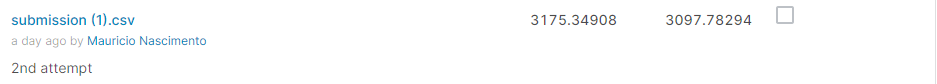

<a id='next-steps'></a>
# Próximos Passos / Oportunidades de melhoria


- **Explorar variáveis com lag de 1 e 2 semanas para vendas semanais:**
    
    Variáveis com a venda semanal da semana anterior ou de 2 semanas atrás para a respectiva combinação loja-departamento têm bastante potencial para agregar em poder preditivo, especialmente para um intervalo curto de predições. Para ilustrar o problema deste método, imagine que hoje queremos fazer uma previsão das vendas semanais para daqui a três semanas. Focando exclusivamente na semana 3, hoje não temos os valores vendidos na semana 1 e na semana 2. O que precisaria ser feito neste caso é fazer uma predição para a semana 1 e usar o resultado da predição da semana 1 para prever a semana 3. Este movimento de usar uma predição anterior para fazer uma nova pode causar uma propagação de erro que venha a prejudicar a performance do modelo para predições de longo prazo.
    

- **"Simplificar" o modelo, entendendo quais variáveis estão sendo mais relevantes para a predição e cortando as irrelevantes:**
    
    Ao analisarmos o PPS vimos que quase nenhuma variável contribuía, individualmente, para a predição. Uma vez que temos o modelo ajustado, podemos fazer um estudo, a partir de técnicas como Permutation Feature Importance ou SHAP, para entender quais variáveis ou combinações de variáveis estão efetivamente contribuindo para o modelo e descartar as variáveis que não agregam poder preditivo.
    
    
- **Ampliar o espaço de busca para os hiperparâmetros e aumentar número de iterações:**

    Devido à restrição de tempo, optou-se por executar apenas 10 ensaios para buscar os hiperparâmetros ótimos para o modelo. Com mais tempo disponível, uma alternativa que poderia trazer melhoras sensíveis à performance do modelo, seria aumentar o número de iterações e ampliar o espaço de busca. É importante ressaltar que, provavelmente, a melhoria de performance seria marginal.


 - **Explorar diferentes abordagens/modelos:**
     
     Nesta solução, optou-se pela estratégia de abordar o problema como uma regressão e utilizar modelos baseados em árvore. Outras possibilidades seriam utilizar modelos estatísticos de séries temporais (SARIMAX, por exemplo) ou mesmo modelos baseados em redes neurais (como LSTM).